In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from qutip.ipynbtools import version_table
from tqdm.notebook import tqdm
from matplotlib.animation import FuncAnimation
from scipy.linalg import expm
import pandas as pd

resol = 200
pi = np.pi
version_table()

Software,Version
QuTiP,5.1.1
Numpy,1.26.2
SciPy,1.11.3
matplotlib,3.7.3
Number of CPUs,11
BLAS Info,Generic
IPython,8.17.2
Python,"3.12.0 (v3.12.0:0fb18b02c8, Oct 2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]"
OS,posix [darwin]
Cython,3.0.11


<h1> State update </h1>

In [2]:
def update_state(c,b,g_0,omega_tab,omega_A,L,t, dt):
    """
    Update the state of the system based on the given parameters.
    
    Parameters:
    c (np array): Coefficients in front of the states |1_k1, 1_k2, 0>
    b (np array): Atomic coefficient in front of the state |1_k, 1>
    g_0 (float): Coupling strength.
    omega_tab (array): Array of frequencies.
    L (int): Length of the system.
    
    Returns:
    c_new (np array): Updated coefficients.
    b_new (float): Updated atomic coefficient.
    """
    g_matrix_individual = 1j * g_0 * np.sqrt(omega_A / L) * np.exp(-1j * (omega_tab - omega_A) * t) 
    g_matrix = np.concatenate((g_matrix_individual, g_matrix_individual))

    c_new = b[:, np.newaxis] * np.conjugate(g_matrix)[np.newaxis, :]
    b_new = c @ g_matrix + g_matrix.T @ c



    return -1j* dt * c_new, -1j * dt * b_new

<h1> RG Scheme </h1>

In [3]:
def RG_scheme(c_init, b_init, g_0, omega_tab, omega_A, L, T, dt, progress_bar=True):
    """
    Propagates the state of the system using the RG scheme.
    
    Parameters:
    c_init (np array): initial coefficients in front of the states |1_k1, 1_k2, 0>
    b_init (np array): initial atomic coefficient in front of the state |1_k, 1>
    g_0 (float): Coupling strength.
    omega_tab (array): Array of frequencies.
    L (float): Length of the system.
    T (float): Total time for propagation.
    dt (float): Time step for propagation.
    
    Returns:
    c_array (np array): Array of c coefficients at each time step.
    b_array (np array): Array of b coefficients at each time step.
    """

    nb_pts_time = int(T / dt)
    n_modes = len(omega_tab)
    c_array = np.zeros((nb_pts_time, 2*n_modes, 2*n_modes), dtype=complex)
    b_array = np.zeros((nb_pts_time, 2*n_modes), dtype=complex)

    # Set the initial conditions
    c_array[0] = c_init
    b_array[0] = b_init

    # Time evolution loop
    for i in tqdm(range(1, nb_pts_time), disable=not progress_bar):
        t = i * dt
        c_current = c_array[i-1]
        b_current = b_array[i-1]

        c_new_k1, b_new_k1 = update_state(c_current, b_current, g_0, omega_tab, omega_A, L, t, dt)
        c_new_k2, b_new_k2 = update_state(c_current + c_new_k1/2, b_current + b_new_k1/2, g_0, omega_tab, omega_A, L, t + dt/2, dt)
        c_new_k3, b_new_k3 = update_state(c_current + c_new_k2/2, b_current + b_new_k2/2, g_0, omega_tab, omega_A, L, t + dt/2, dt)
        c_new_k4, b_new_k4 = update_state(c_current + c_new_k3, b_current + b_new_k3, g_0, omega_tab, omega_A, L, t + dt, dt)

        c_new = c_current + (c_new_k1 + 2*c_new_k2 + 2*c_new_k3 + c_new_k4) / 6
        b_new = b_current + (b_new_k1 + 2*b_new_k2 + 2*b_new_k3 + b_new_k4) / 6

        c_array[i] = c_new
        b_array[i] = b_new

    return c_array, b_array 
    

<h1> Function that treats the whole evolution </h1>

In [4]:
def get_data_bs_fast(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, x_1, print_info = False, progress_bar=True):
    """
    Generate data for the RG scheme with a beamsplitter.
    
    Parameters:
    L (float): Length of the system.
    T (float): Total time for propagation.
    dt (float): Time step for propagation.
    omega_0 (float): Frequency of the photon
    omega_A (float): Frequency of the atom
    omega_max (float): Maximum frequency for the modes.
    g_0 (float): Coupling strength.
    sigma (float): Width of the Gaussian wave packet in position space.
    x_0 (float): Position of the first Gaussian peak.
    x_1 (float): Position of the second Gaussian peak.
    print_nb_modes (bool): Whether to print the number of modes used.
    
    Returns:
    c_array (np array): Coefficients in front of the states |1_k1, 1_k2, 0>.
    b_array (np array): Coefficients in front of the state |1_k, 1>.
    overlap_tab (np array): Array of overlaps with the initial state.
    """
    
    #quantization of the modes
    omega_tab_p = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
    #k_tab_individual = np.sort(np.unique(np.concatenate((-omega_tab_p, omega_tab_p))))
    k_tab_individual = np.copy(omega_tab_p) #only positive modes
    n_modes = len(k_tab_individual) #number of modes in each waveguide
    omega_tab_individual = np.abs(k_tab_individual)

    if print_info:
        print("Number of modes: ", n_modes)
        print("Dimension of the Hilbert space: ", n_modes*(2*n_modes + 3))
        
    
    #prepare the initial state
    if print_info:
        print("Preparing the initial state...")
    c_init = np.zeros((2*n_modes, 2*n_modes), dtype=complex)
    b_init = np.zeros(2*n_modes, dtype=complex)

    #for a in range(n_modes):
    #    for b in range(n_modes):
    #        k_a = k_tab_individual[a]
    #        k_b = k_tab_individual[b]

    #        c_a = np.exp(-0.5*sigma**2*(k_a - omega_0)**2 -1j * k_a * x_0)
    #        c_b = np.exp(-0.5*sigma**2*(k_b - omega_0)**2 -1j * k_b * x_1)
            
    #        c_init[a, n_modes + b] = c_a * c_b
    #        c_init[n_modes + b, a] = c_init[a, n_modes + b]

    c_a_individual = np.exp(-0.5*sigma**2*(k_tab_individual - omega_0)**2 -1j * k_tab_individual * x_0)
    c_a_individual /= np.sqrt(np.sum(np.abs(c_a_individual)**2)) #normalize the individual wavepacket
    c_a = np.concatenate((c_a_individual, np.zeros(n_modes))) #put it in the first waveguide

    c_b_individual = np.exp(-0.5*sigma**2*(k_tab_individual - omega_0)**2 -1j * k_tab_individual * x_1)
    c_b_individual /= np.sqrt(np.sum(np.abs(c_b_individual)**2)) #normalize the individual wavepacket
    c_b = np.concatenate((np.zeros(n_modes), c_b_individual)) #put it in the second waveguide

    c_init = c_a[:, np.newaxis] * c_b[np.newaxis, :]
    c_init = (c_init + c_init.T) / np.sqrt(2)
    norm = np.sqrt(np.sum(np.abs(c_init)**2))
    c_init /= norm

    ##evolve the state
    if print_info:
        print("Evolving the state...")
    c_array, b_array = RG_scheme(c_init, b_init, g_0, omega_tab_individual, omega_A, L, T, dt, progress_bar=progress_bar)

    ##compute the overlap with the initial state
    if print_info:
        print("Computing the overlap with the initial state...")
    overlap_tab = np.zeros(int(T / dt))

    for i in tqdm(range(int(T / dt)), disable=not progress_bar):
        c_current = c_array[i]
        b_current = b_array[i]
        overlap_tab[i] = np.abs(np.sum(np.conjugate(c_init) * c_current))**2 + np.abs(np.conjugate(b_init) @ b_current)**2

    return c_array, b_array, overlap_tab

<h1> First test </h1>

Some checks

In [5]:
L = 5*pi
T = L/2
dt = 0.01

#Jaynes-Cummings parameter g_0 and energies 
g_0 = 1
omega_A = 3
omega_0 = 6.7
omega_max = 10

#initial photon wavepacket parameters
sigma = L/6
sigma_momentum = 1/sigma

x_0 = -L/4
delta_x = 0*sigma
x_1 = x_0 + delta_x

#check some parameters
gamma = g_0**2 * omega_A
print("50% Reflectivity for omega_0_m = ", omega_A - gamma, " and omega_0_p = ", omega_A + gamma)

50% Reflectivity for omega_0_m =  0  and omega_0_p =  6


Run the calculations

In [6]:
c_array, b_array, overlap_tab = get_data_bs_fast(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, x_1, print_info = True, progress_bar=True)

Number of modes:  26
Dimension of the Hilbert space:  1430
Preparing the initial state...
Evolving the state...


  0%|          | 0/784 [00:00<?, ?it/s]

Computing the overlap with the initial state...


  0%|          | 0/785 [00:00<?, ?it/s]

<h1> Coherence and atom excitation </h1>

In [7]:
time_array = np.linspace(0, T, int(T / dt))

nb_pts_time = int(T / dt)
atom_excitation = np.zeros(nb_pts_time)
#get the number of modes
n_modes = c_array[0].shape[0] // 2

for i in tqdm(range(nb_pts_time)):
    c_current, b_current = c_array[i], b_array[i]
    atom_excitation[i] = np.sum(np.abs(b_current)**2)

  0%|          | 0/785 [00:00<?, ?it/s]

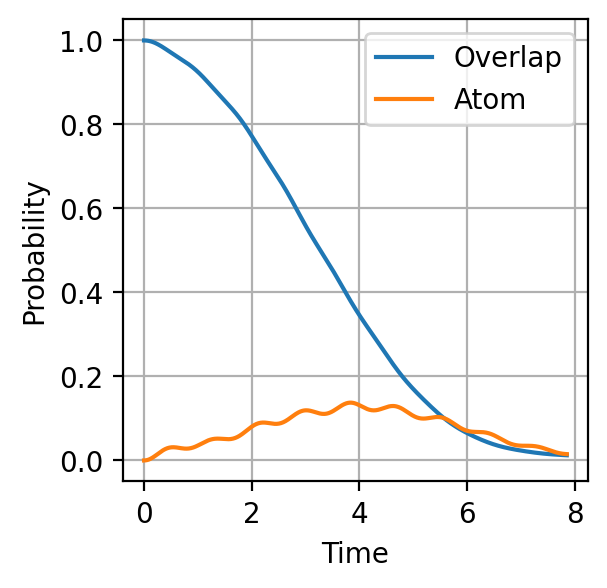

In [8]:
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
ax.plot(time_array, overlap_tab, label='Overlap')
#ax.plot(time_array, coherence,label='Coherence', linestyle='-', color='blue', alpha=0.5)
ax.plot(time_array, atom_excitation,label='Atom')
ax.set_xlabel('Time')
ax.set_ylabel('Probability')
ax.legend()
ax.grid()

plt.show()

Sanity check : HOM effect

In [9]:
print("Final overlap: ", overlap_tab[-1])
print("Theorytical value: ", 0.5 * (1 - np.exp(-0.5 * (np.abs(x_0 - x_1) / sigma)**2)))

Final overlap:  0.012329870455354539
Theorytical value:  0.0


Just try to visualize c_init

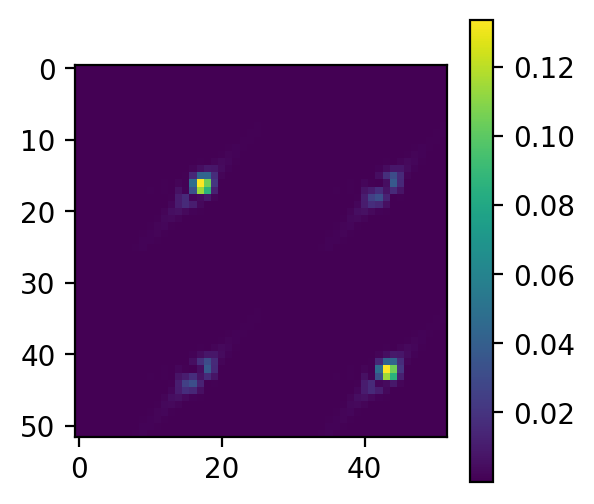

In [12]:
c_init = c_array[-1]
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)
im = ax.imshow(np.abs(c_init)**2)
plt.colorbar(im, ax=ax)
plt.show()

<h1> HOM effect ? </h1>

In [13]:
L = 5*pi
T = L/2
dt = 0.005

#Jaynes-Cummings parameter g_0 and energies 
g_0 = 1
omega_A = 3
omega_0 = 6.7
omega_max = 10

#initial photon wavepacket parameters
sigma = L/5
sigma_momentum = 1/sigma
x_0 = -L/4

#prepare several values of delta_x
nb_pts_x = 9
delta_x_tab = np.linspace(-3*sigma, 3*sigma, nb_pts_x)
final_overlap_free_tab = np.zeros(nb_pts_x)

for i in tqdm(range(nb_pts_x)):
    delta_x = delta_x_tab[i]
    x_1 = x_0 + delta_x
    c_array, b_array, overlap_tab = get_data_bs_fast(L, T, dt, omega_0, omega_A, omega_max, g_0, sigma, x_0, x_1, print_info = False, progress_bar=False)
    final_overlap_free_tab[i] = overlap_tab[-1]

  0%|          | 0/9 [00:00<?, ?it/s]

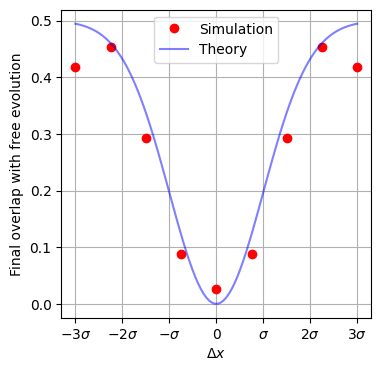

In [14]:
delta_x_theory = np.linspace(-3*sigma, 3*sigma, 100)
overlap_theory = 0.5*(1- np.exp(- (delta_x_theory**2) / (2*sigma**2)))

fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(delta_x_tab, final_overlap_free_tab, 'o', label="Simulation", color='red')
ax.plot(delta_x_theory, overlap_theory, label="Theory", color="blue", alpha=0.5)
ax.set_xlabel(r"$\Delta x$")
ax.set_ylabel("Final overlap with free evolution")
ax.set_xticks(np.array([-3,-2, -1, 0, 1, 2, 3])*sigma)
ax.set_xticklabels([r"$-3\sigma$", r"$-2\sigma$", r"$-\sigma$", "0", r"$\sigma$", r"$2\sigma$", r"$3\sigma$"])
ax.grid()
ax.legend()
plt.show()